# Introduction

This notebook is written to demonstrate the use of M3GNet as a structure relaxer as well as to provide more comprehensive benchmarks for cubic crystals based on exp data on Wikipedia and MP DFT data. This benchmark is limited to cubic crystals for ease of comparison since there is only one lattice parameter. 

If you are running this notebook from Google Colab, uncomment the next code box to install m3gnet first.

In [ ]:
# !pip install m3gnet

In [ ]:
from __future__ import annotations

import traceback
import warnings

import numpy as np
import pandas as pd
from pymatgen.core import Composition, Lattice, Structure
from pymatgen.ext.matproj import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from tqdm import tqdm

from matgl.apps.pes import Potential
from matgl.ext.ase import Relaxer
from matgl.models import M3GNet

for category in (UserWarning, DeprecationWarning):
    warnings.filterwarnings("ignore", category=category, module="tensorflow")
    warnings.filterwarnings("ignore", category=category, module="pymatgen")

The next cell just compiles data from Wikipedia. 

In [ ]:
data = pd.read_html("http://en.wikipedia.org/wiki/Lattice_constant")[0]
data = data[
    ~data["Crystal structure"].isin(
        ["Hexagonal", "Wurtzite", "Wurtzite (HCP)", "Orthorhombic", "Tetragonal perovskite", "Orthorhombic perovskite"]
    )
]
data = data.rename(columns={"Lattice constant (Å)": "a (Å)"})
data = data.drop(columns=["Ref."])
data["a (Å)"] = data["a (Å)"].map(float)
data = data[["Material", "Crystal structure", "a (Å)"]]


additional_fcc = """10 Ne 4.43 54 Xe 6.20
13 Al 4.05 58 Ce 5.16
18 Ar 5.26 70 Yb 5.49
20 Ca 5.58 77 Ir 3.84
28 Ni 3.52 78 Pt 3.92
29 Cu 3.61 79 Au 4.08
36 Kr 5.72 82 Pb 4.95
38 Sr 6.08 47 Ag 4.09
45 Rh 3.80 89 Ac 5.31
46 Pd 3.89 90 Th 5.08"""

additional_bcc = """3 Li 3.49 42 Mo 3.15
11 Na 4.23 55 Cs 6.05
19 K 5.23 56 Ba 5.02
23 V 3.02 63 Eu 4.61
24 Cr 2.88 73 Ta 3.31
26 Fe 2.87 74 W 3.16
37 Rb 5.59 41 Nb 3.30"""


def add_new(str_, structure_type, df):
    tokens = str_.split()
    new_crystals = []
    for i in range(int(len(tokens) / 3)):
        el = tokens[3 * i + 1].strip()
        if el not in df["Material"].to_numpy():
            new_crystals.append([tokens[3 * i + 1], structure_type, float(tokens[3 * i + 2])])
    df2 = pd.DataFrame(new_crystals, columns=data.columns)
    return pd.concat([df, df2])


data = add_new(additional_fcc, "FCC", data)
data = add_new(additional_bcc, "BCC", data)
data = data[data["Material"] != "NC0.99"]
data = data[data["Material"] != "Xe"]
data = data[data["Material"] != "Kr"]
data = data[data["Material"] != "Rb"]
data = data.set_index("Material")
print(data)

             Crystal structure     a (Å)
Material                                
C (diamond)      Diamond (FCC)  3.567000
Si               Diamond (FCC)  5.431021
Ge               Diamond (FCC)  5.658000
AlAs         Zinc blende (FCC)  5.660500
AlP          Zinc blende (FCC)  5.451000
...                        ...       ...
Cs                         BCC  6.050000
K                          BCC  5.230000
Ba                         BCC  5.020000
Eu                         BCC  4.610000
Cr                         BCC  2.880000

[89 rows x 2 columns]


In the next cell, we generate an initial structure for all the phases. The cubic constant is set to an arbitrary value of 5 angstroms for all structures. It does not matter too much what you set it to, but it cannot be too large or it will result in isolated atoms due to the cutoffs used in m3gnet to determine bonds. We then call the Relaxer, which is the M3GNet universal IAP pre-trained on the Materials Project.

In [ ]:
predicted = []
mp = []
mpr = MPRester("eS2D85Pp6h1zRg7I3dVxH1vUndN9CeTk")

# load the pre-trained M3GNet model. By default it is the model trained to MP-2021.2.8 database.
model, d = M3GNet.load("M3GNet-MP-2021.2.8-PES", include_json=True)
metadata = d["metadata"]
data_std = metadata["data_std"]
data_mean = metadata["data_mean"]
element_refs = metadata["element_refs"]
# create the potential class
ff = Potential(model, data_std=data_std, element_refs=element_refs)
# create the M3GNet Relaxer
relaxer = Relaxer(potential=ff)

# warnings.filterwarnings(action="ignore", category=UserWarning, module="tensorflow")

for formula, v in tqdm(data.iterrows(), total=len(data)):
    formula = formula.split()[0]
    c = Composition(formula)
    els = sorted(c.elements)
    cs = v["Crystal structure"]

    # We initialize all the crystals with an arbitrary lattice constant of 5 angstroms.
    if "Zinc blende" in cs:
        s = Structure.from_spacegroup("F-43m", Lattice.cubic(4.5), [els[0], els[1]], [[0, 0, 0], [0.25, 0.25, 0.75]])
    elif "Halite" in cs:
        s = Structure.from_spacegroup("Fm-3m", Lattice.cubic(4.5), [els[0], els[1]], [[0, 0, 0], [0.5, 0, 0]])
    elif "Caesium chloride" in cs:
        s = Structure.from_spacegroup("Pm-3m", Lattice.cubic(4.5), [els[0], els[1]], [[0, 0, 0], [0.5, 0.5, 0.5]])
    elif "Cubic perovskite" in cs:
        s = Structure(
            Lattice.cubic(5),
            [els[0], els[1], els[2], els[2], els[2]],
            [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, 0], [0.0, 0.5, 0.5], [0.5, 0, 0.5]],
        )
    elif "Diamond" in cs:
        s = Structure.from_spacegroup("Fd-3m", Lattice.cubic(5), [els[0]], [[0.25, 0.75, 0.25]])
    elif "BCC" in cs:
        s = Structure(Lattice.cubic(4.5), [els[0]] * 2, [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]])
    elif "FCC" in cs:
        s = Structure(Lattice.cubic(4.5), [els[0]] * 4, [[0.0, 0.0, 0.0], [0.5, 0.5, 0], [0.0, 0.5, 0.5], [0.5, 0, 0.5]])
    else:
        predicted.append(0)
        mp.append(0)
        continue

    # print(s.composition.reduced_formula)
    relax_results = relaxer.relax(s, fmax=0.01)

    final_structure = relax_results["final_structure"]

    predicted.append(final_structure.lattice.a)

    try:
        mids = mpr.get_material_ids(s.composition.reduced_formula)
        for i in mids:
            try:
                structure = mpr.get_structure_by_material_id(i)
                sga = SpacegroupAnalyzer(structure)
                sga2 = SpacegroupAnalyzer(final_structure)
                if sga.get_space_group_number() == sga2.get_space_group_number():
                    conv = sga.get_conventional_standard_structure()
                    mp.append(conv.lattice.a)
                    break
            except Exception:
                pass
        else:
            raise RuntimeError
    except Exception:
        mp.append(0)
        traceback.print_exc()

data["MP a (Å)"] = mp
data["Predicted a (Å)"] = predicted

/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(
  0%|                                                                                                                         | 0/89 [00:00<?, ?it/s]/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  return th.as_tensor(data, dtype=dtype)
/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will

Retrieving MaterialsDoc documents:   0%|          | 0/62 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|█▎                                                                                                               | 1/89 [00:02<04:15,  2.91s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/42 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|██▌                                                                                                              | 2/89 [00:05<03:43,  2.57s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/17 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|███▊                                                                                                             | 3/89 [00:06<03:07,  2.18s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|█████                                                                                                            | 4/89 [00:09<03:22,  2.38s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|██████▎                                                                                                          | 5/89 [00:12<03:22,  2.41s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|███████▌                                                                                                         | 6/89 [00:14<03:23,  2.45s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|████████▉                                                                                                        | 7/89 [00:16<03:11,  2.34s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/13 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|██████████▏                                                                                                      | 8/89 [00:19<03:16,  2.43s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|███████████▍                                                                                                     | 9/89 [00:22<03:22,  2.53s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|████████████▌                                                                                                   | 10/89 [00:24<03:15,  2.48s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█████████████▊                                                                                                  | 11/89 [00:26<02:53,  2.23s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/11 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|███████████████                                                                                                 | 12/89 [00:28<02:45,  2.15s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/23 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|████████████████▎                                                                                               | 13/89 [00:30<02:48,  2.21s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█████████████████▌                                                                                              | 14/89 [00:33<02:58,  2.38s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|██████████████████▉                                                                                             | 15/89 [00:36<03:09,  2.56s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|████████████████████▏                                                                                           | 16/89 [00:38<02:52,  2.36s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█████████████████████▍                                                                                          | 17/89 [00:41<03:05,  2.58s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/146 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██████████████████████▋                                                                                         | 18/89 [00:44<03:12,  2.71s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/19 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/var/folders/w6/yrmcztx969j0r2f2v6yy3gp00000gn/T/ipykernel_46283/1567234812.py", line 69, in <module>
    raise RuntimeError
RuntimeError
 21%|███████████████████████▉                                                                                        | 19/89 [00:50<04:23,  3.76s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|█████████████████████████▏                                                                                      | 20/89 [00:54<04:23,  3.82s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/27 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██████████████████████████▍                                                                                     | 21/89 [00:59<04:47,  4.23s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|███████████████████████████▋                                                                                    | 22/89 [01:02<04:17,  3.84s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|████████████████████████████▉                                                                                   | 23/89 [01:08<04:51,  4.42s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██████████████████████████████▏                                                                                 | 24/89 [01:13<04:58,  4.58s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|███████████████████████████████▍                                                                                | 25/89 [01:15<04:14,  3.98s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|████████████████████████████████▋                                                                               | 26/89 [01:18<03:43,  3.55s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|█████████████████████████████████▉                                                                              | 27/89 [01:21<03:26,  3.33s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███████████████████████████████████▏                                                                            | 28/89 [01:23<03:00,  2.96s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|████████████████████████████████████▍                                                                           | 29/89 [01:25<02:40,  2.67s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|█████████████████████████████████████▊                                                                          | 30/89 [01:27<02:38,  2.68s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███████████████████████████████████████                                                                         | 31/89 [01:29<02:17,  2.37s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|████████████████████████████████████████▎                                                                       | 32/89 [01:31<02:04,  2.18s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|█████████████████████████████████████████▌                                                                      | 33/89 [01:34<02:10,  2.33s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████▊                                                                     | 34/89 [01:36<02:04,  2.26s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████                                                                    | 35/89 [01:39<02:16,  2.52s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████▎                                                                  | 36/89 [01:42<02:21,  2.67s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████▌                                                                 | 37/89 [01:44<02:16,  2.63s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|███████████████████████████████████████████████▊                                                                | 38/89 [01:46<02:05,  2.46s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|█████████████████████████████████████████████████                                                               | 39/89 [01:49<01:58,  2.38s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████▎                                                             | 40/89 [01:50<01:39,  2.04s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████▌                                                            | 41/89 [01:52<01:37,  2.02s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████████████████████████████████████████████████████▊                                                           | 42/89 [01:53<01:19,  1.70s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|██████████████████████████████████████████████████████                                                          | 43/89 [01:53<01:04,  1.40s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████▎                                                        | 44/89 [01:54<00:58,  1.29s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████▋                                                       | 45/89 [01:56<00:58,  1.34s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████▉                                                      | 46/89 [01:57<00:48,  1.12s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████▏                                                    | 47/89 [01:58<00:48,  1.16s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|████████████████████████████████████████████████████████████▍                                                   | 48/89 [01:59<00:43,  1.05s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 49/89 [02:00<00:40,  1.02s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                 | 50/89 [02:01<00:42,  1.08s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|████████████████████████████████████████████████████████████████▏                                               | 51/89 [02:02<00:37,  1.01it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                              | 52/89 [02:02<00:30,  1.20it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                             | 53/89 [02:03<00:29,  1.22it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                            | 54/89 [02:04<00:28,  1.24it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                          | 55/89 [02:05<00:30,  1.11it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                         | 56/89 [02:10<01:16,  2.31s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████▋                                        | 57/89 [02:14<01:23,  2.62s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                       | 58/89 [02:16<01:16,  2.47s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                     | 59/89 [02:20<01:28,  2.95s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                    | 60/89 [02:23<01:29,  3.08s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                   | 61/89 [02:29<01:45,  3.75s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                  | 62/89 [02:32<01:35,  3.53s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                                | 63/89 [02:35<01:27,  3.38s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▌                               | 64/89 [02:38<01:23,  3.32s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 65/89 [02:41<01:15,  3.16s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████                             | 66/89 [02:43<01:09,  3.04s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                           | 67/89 [02:46<01:04,  2.92s/it]Traceback (most recent call last):
  File "/var/folders/w6/yrmcztx969j0r2f2v6yy3gp00000gn/T/ipykernel_46283/1567234812.py", line 56, in <module>
    mids = mpr.get_material_ids(s.composition.reduced_formula)
  File "/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/mprester.py", line 417, in get_material_ids
    for doc in self.materials.search(
  File "/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/routes/materials.py", line 172, in search
    return super()._search(
  File "/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/core/client.py", line 940, in _search
    return self._get_all_documents(
  File "/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/core/client.py", line 987, in _get_all_documents
    results = self._query_re

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 69/89 [03:20<03:18,  9.93s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                        | 70/89 [03:36<03:43, 11.79s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                      | 71/89 [03:54<04:04, 13.57s/it]Traceback (most recent call last):
  File "/var/folders/w6/yrmcztx969j0r2f2v6yy3gp00000gn/T/ipykernel_46283/1567234812.py", line 56, in <module>
    mids = mpr.get_material_ids(s.composition.reduced_formula)
  File "/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/mprester.py", line 417, in get_material_ids
    for doc in self.materials.search(
  File "/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/routes/materials.py", line 172, in search
    return super()._search(
  File "/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/core/client.py", line 940, in _search
    return self._get_all_documents(
  File "/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/core/client.py", line 987, in _get_all_documents
    results = self._query_re

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▊                    | 73/89 [04:16<02:58, 11.17s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████                   | 74/89 [04:16<01:59,  7.96s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                 | 75/89 [04:17<01:20,  5.77s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                | 76/89 [04:18<00:58,  4.47s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 77/89 [04:19<00:39,  3.33s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏             | 78/89 [04:20<00:30,  2.75s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/11 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▍            | 79/89 [04:21<00:21,  2.11s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 80/89 [04:22<00:17,  1.91s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 81/89 [04:23<00:11,  1.49s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 82/89 [04:23<00:08,  1.26s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 83/89 [04:24<00:07,  1.17s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/14 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 84/89 [04:25<00:04,  1.00it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/15 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 85/89 [04:25<00:03,  1.18it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/20 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 86/89 [04:26<00:02,  1.38it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/11 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/var/folders/w6/yrmcztx969j0r2f2v6yy3gp00000gn/T/ipykernel_46283/1567234812.py", line 69, in <module>
    raise RuntimeError
RuntimeError
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 87/89 [04:28<00:02,  1.17s/it]

Retrieving MaterialsDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 88/89 [04:28<00:00,  1.09it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [04:30<00:00,  3.04s/it]


In [ ]:
data["% error vs Expt"] = (data["Predicted a (Å)"] - data["a (Å)"]) / data["a (Å)"]
data["% error vs MP"] = (data["Predicted a (Å)"] - data["MP a (Å)"]) / data["MP a (Å)"]

In [ ]:
data.sort_index().style.format({"% error vs Expt": "{:,.2%}", "% error vs MP": "{:,.2%}"}).background_gradient()

/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/pandas/io/formats/style.py:3935: RuntimeWarning: invalid value encountered in scalar multiply
  norm = mpl.colors.Normalize(smin - (rng * low), smax + (rng * high))


,Crystal structure,a (Å),MP a (Å),Predicted a (Å),% error vs Expt,% error vs MP
Material,,,,,,
Ac,FCC,5.310000,5.696211,5.613508,5.72%,-1.45%
Ag,FCC,4.079000,4.104356,4.172203,2.28%,1.65%
Al,FCC,4.046000,4.038930,4.046954,0.02%,0.20%
AlAs,Zinc blende (FCC),5.660500,5.675802,5.730905,1.24%,0.97%
AlP,Zinc blende (FCC),5.451000,5.472967,5.489397,0.70%,0.30%
AlSb,Zinc blende (FCC),6.135500,6.185042,6.228938,1.52%,0.71%
Ar,FCC,5.260000,5.363160,4.145401,-21.19%,-22.71%
Au,FCC,4.065000,4.171289,4.168613,2.55%,-0.06%
BN,Zinc blende (FCC),3.615000,3.626002,3.615134,0.00%,-0.30%


<Axes: >

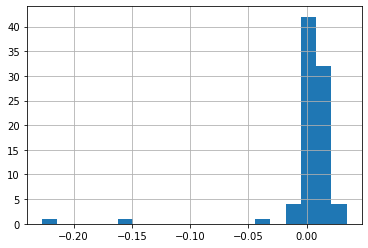

In [ ]:
data["% error vs MP"].replace([np.inf, -np.inf], np.nan).dropna().hist(bins=20)